In [1]:
%pip install wfdb


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import wfdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import ast

In [4]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [5]:
path = "/Users/annaorlova/Desktop/ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/"

In [6]:
sampling_rate = 100 

In [7]:
import os

if os.path.exists(path):
    print(f"Путь '{path}' найден!")
else:
    print(f"Путь '{path}' не найден. Проверьте корректность пути.")


Путь '/Users/annaorlova/Desktop/ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/' найден!


In [8]:
try:
    with open(path + 'ptbxl_database.csv', 'r') as file:
        print("Файл открыт успешно.")
except PermissionError as e:
    print(f"Ошибка доступа: {e}")

Файл открыт успешно.


In [9]:

Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id') ## взять парочку и запустить с ними
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [10]:
sample_size = 2
Y_sample = Y.head(sample_size)

In [11]:
#signal data
X_sample = load_raw_data(Y_sample, sampling_rate, path)

#diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

In [12]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

## Visualization

In [43]:
Y_sample['diagnostic_superclass'] = Y_sample.scp_codes.apply(aggregate_diagnostic)

In [15]:
import matplotlib.pyplot as plt

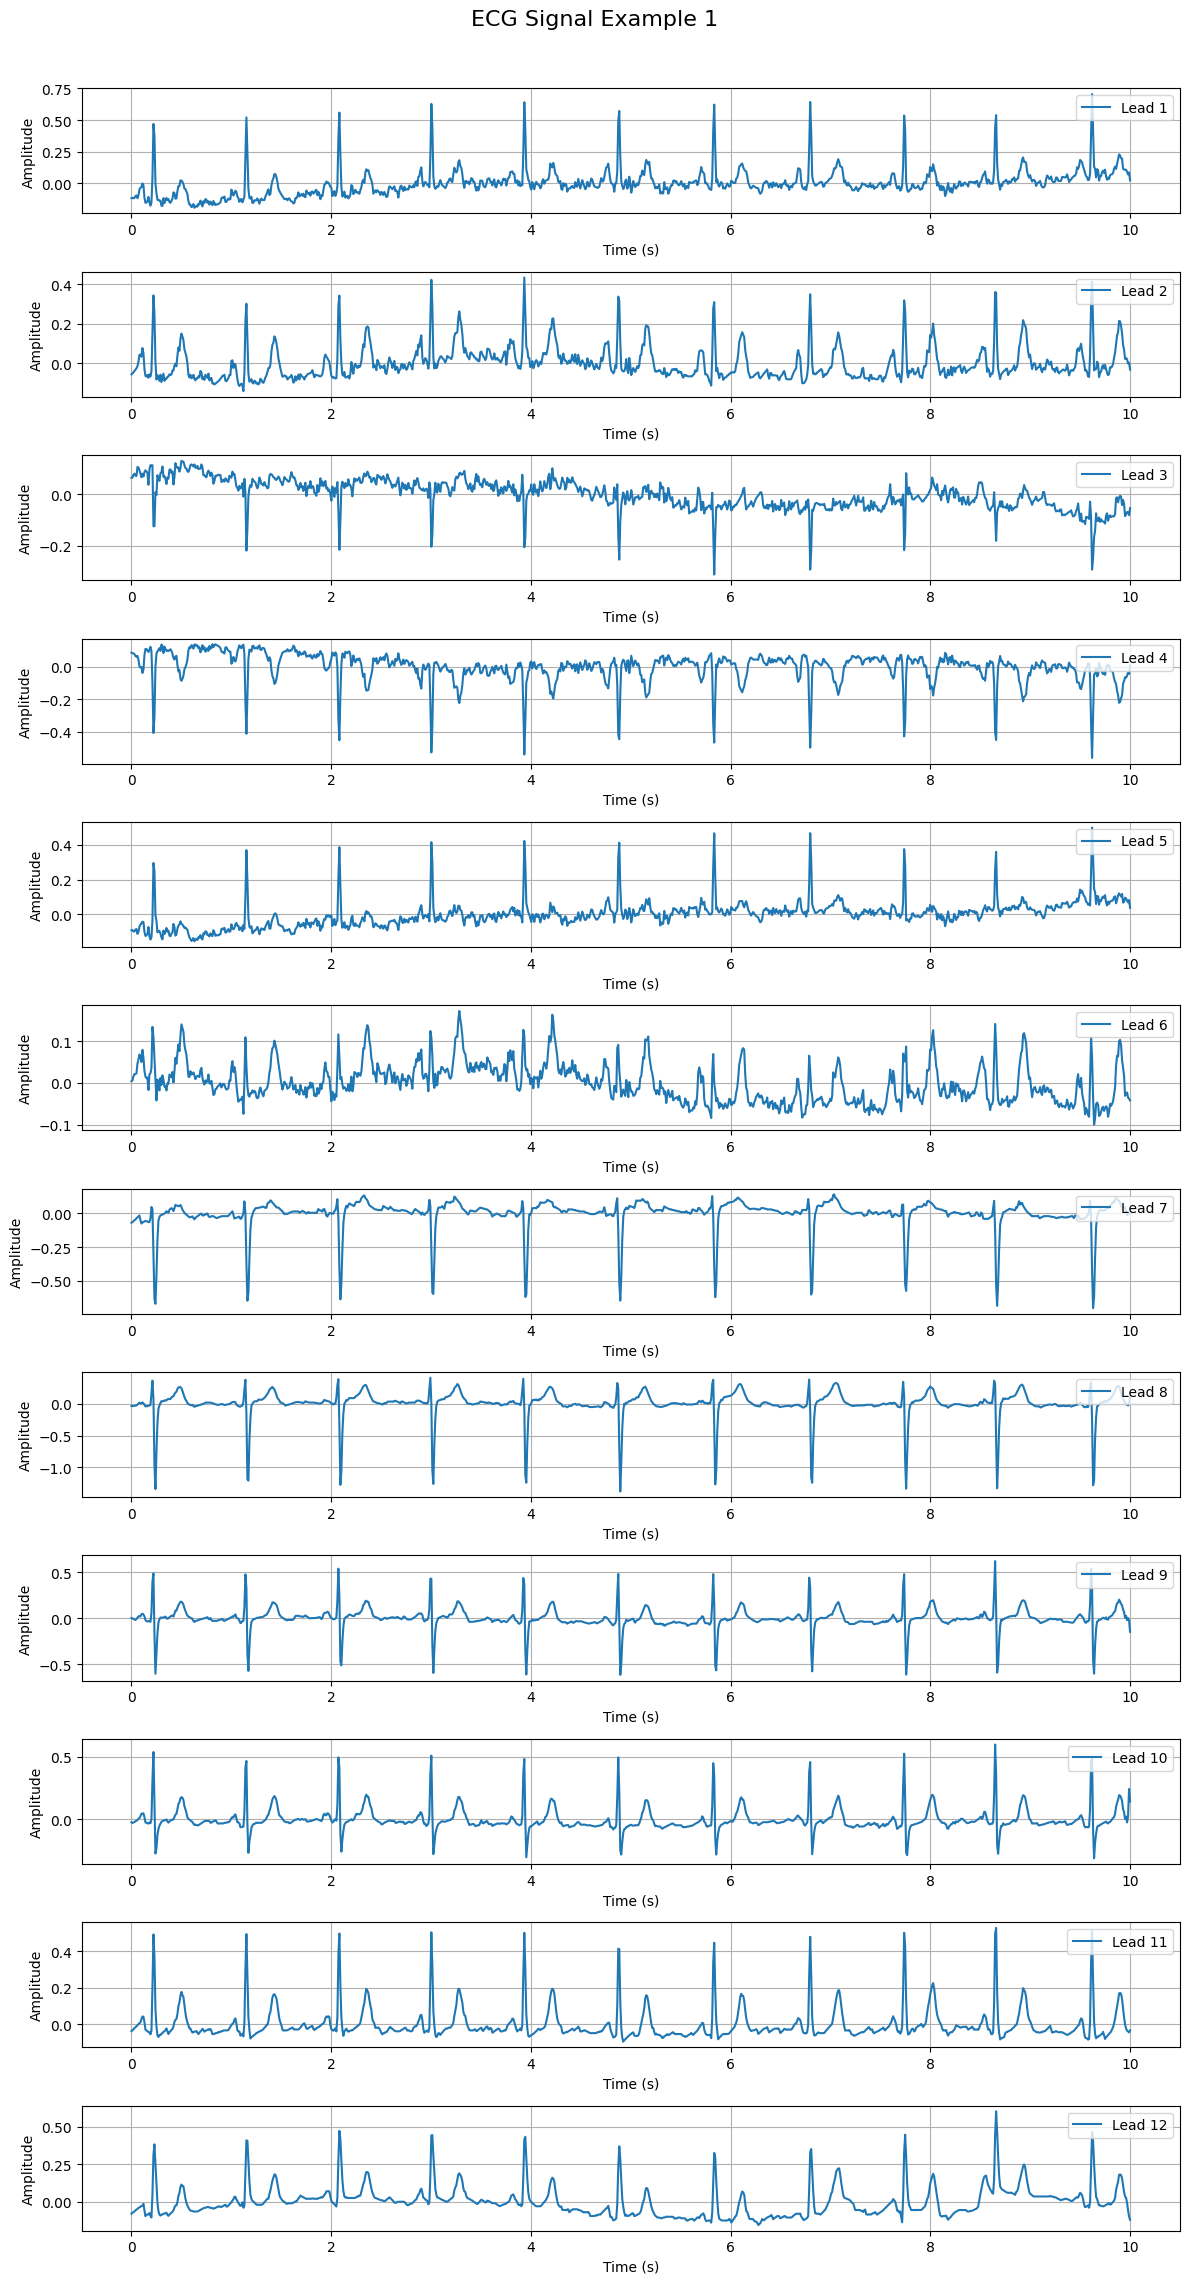

In [16]:
def plot_ecg(signal, sampling_rate, title="ECG Signal", leads=12):

    time = np.linspace(0, signal.shape[0] / sampling_rate, signal.shape[0])

    plt.figure(figsize=(12, 2 * leads))
    for i in range(leads):
        plt.subplot(leads, 1, i + 1)
        plt.plot(time, signal[:, i], label=f"Lead {i+1}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend(loc="upper right")
        plt.grid()
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

example_index = 0
example_signal = X_sample[example_index]

plot_ecg(example_signal, sampling_rate, title=f"ECG Signal Example {example_index+1}")

## Dataframe for training 

In [45]:
import pandas as pd
import numpy as np
import os
import ast

base_path = "/Users/annaorlova/Desktop/ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
records_path = os.path.join(base_path, "records100")
database_path = os.path.join(base_path, "ptbxl_database.csv")
scp_statements_path = os.path.join(base_path, "scp_statements.csv")

Y = pd.read_csv(database_path, index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval) 

agg_df = pd.read_csv(scp_statements_path, index_col=0)
agg_df = agg_df[agg_df['diagnostic'] == 1]  

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key]['diagnostic_class'])
    return list(set(tmp))

Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)

def get_record_path(filename, records_path):
    return os.path.join(records_path, filename + ".hea")


#Y['path_to_record'] = Y['filename_lr'].apply(lambda x: get_record_path(x, records_path))
Y['path_to_record'] = Y['filename_lr'].apply(lambda x: os.path.join(base_path, x))


diagnosis_dummies = Y['diagnostic_superclass'].explode().str.get_dummies().groupby(level=0).max()


df = pd.concat([Y[['path_to_record']], diagnosis_dummies], axis=1)


print(df.head())


                                           path_to_record  CD  HYP  MI  NORM  \
ecg_id                                                                         
1       /Users/annaorlova/Desktop/ecg/ptb-xl-a-large-p...   0    0   0     1   
2       /Users/annaorlova/Desktop/ecg/ptb-xl-a-large-p...   0    0   0     1   
3       /Users/annaorlova/Desktop/ecg/ptb-xl-a-large-p...   0    0   0     1   
4       /Users/annaorlova/Desktop/ecg/ptb-xl-a-large-p...   0    0   0     1   
5       /Users/annaorlova/Desktop/ecg/ptb-xl-a-large-p...   0    0   0     1   

        STTC  
ecg_id        
1          0  
2          0  
3          0  
4          0  
5          0  


In [14]:
sum = np.sum(df['NORM'])
sum

9514

In [46]:
sum = np.sum(df['CD'])
sum

4898

In [16]:
import pandas as pd
import numpy as np
import os
import wfdb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

2025-03-05 01:36:49.431720: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [52]:
def load_ecg_signal(record_path):
    try:
        record = wfdb.rdrecord(record_path) 
        signal = record.p_signal[:, 0]       
        return signal
    except Exception as e:
        print(f"Ошибка при загрузке записи {record_path}: {e}")
        return None


In [53]:
X = []
y = []

for _, row in df.iterrows():
    try:
        record = wfdb.rdrecord(row['path_to_record'])
        
        signal = record.p_signal
        
        X.append(signal)
        
        y.append(row[['CD', 'HYP', 'MI', 'NORM', 'STTC']].values.astype(int))
    except Exception as e:
        print(f"Ошибка при чтении файла {row['path_to_record']}: {e}")


X = np.array(X) 
y = np.array(y) 


print(f"Размерность X: {X.shape}")
print(f"Размерность y: {y.shape}")


Размерность X: (21799, 1000, 12)
Размерность y: (21799, 5)


## Dataset

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np


In [21]:
import torch.nn.functional as F


In [25]:
pip install iterstrat.ml_stratifiers

ERROR: Could not find a version that satisfies the requirement iterstrat.ml_stratifiers (from versions: none)
ERROR: No matching distribution found for iterstrat.ml_stratifiers

[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [26]:
pip install iterative-stratification


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [27]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np

# Создаём стратифицированное разбиение
skf = MultilabelStratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Генерируем индексы для разбиения
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    break  # Берем только одно разбиение

print(f"Размерность X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Размерность y_train: {y_train.shape}, y_test: {y_test.shape}")

Размерность X_train: (14533, 1000, 12), X_test: (7266, 1000, 12)
Размерность y_train: (14533, 5), y_test: (7266, 5)


In [28]:
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)

        if x.ndim == 2 and x.shape[1] == 12:
            x = x.permute(1, 0)  # (1000, 12) → (12, 1000)
        elif x.shape == (12, 8192):
            x = x.unsqueeze(1)  # (12, 8192) → (12, 1, 8192)
        else:
            raise ValueError(f"Unexpected shape: {x.shape}")

        x = x.unsqueeze(1)  # Добавляем доп. измерение (каналы)
        return x, torch.tensor(self.y[idx], dtype=torch.float32)

# Создаём стратифицированное разбиение
skf = MultilabelStratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Генерируем индексы для разбиения
for train_index, test_val_index in skf.split(X, y):
    X_train, X_test_val = X[train_index], X[test_val_index]
    y_train, y_test_val = y[train_index], y[test_val_index]
    break  # Берем только одно разбиение

# Разделяем test_val на валидацию и тест (50/50)
skf_val_test = MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=42)
for val_index, test_index in skf_val_test.split(X_test_val, y_test_val):
    X_val, X_test = X_test_val[val_index], X_test_val[test_index]
    y_val, y_test = y_test_val[val_index], y_test_val[test_index]
    break

print(f"Размерность X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
print(f"Размерность y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}")

# Создаём датасеты
train_dataset = ECGDataset(X_train, y_train)
val_dataset = ECGDataset(X_val, y_val)
test_dataset = ECGDataset(X_test, y_test)

# Создаём DataLoader'ы
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Проверяем размерность одного батча
data_iter = iter(train_loader)
inputs, labels = next(data_iter)

print(inputs.shape)  # Должно быть torch.Size([32, 12, 1000])


Размерность X_train: (14533, 1000, 12), X_val: (3633, 1000, 12), X_test: (3633, 1000, 12)
Размерность y_train: (14533, 5), y_val: (3633, 5), y_test: (3633, 5)
torch.Size([32, 12, 1, 1000])


## ISIBIRNA

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyResidualBlock(nn.Module):
    def __init__(self, downsample=False):
        super(MyResidualBlock, self).__init__()
        self.downsample = downsample
        self.stride = 2 if self.downsample else 1
        K = 9
        P = (K - 1) // 2

        self.conv1 = nn.Conv2d(256, 256, (1, K), stride=(1, self.stride), padding=(0, P), bias=False)
        self.bn1 = nn.BatchNorm2d(256)

        self.conv2 = nn.Conv2d(256, 256, (1, K), padding=(0, P), bias=False)
        self.bn2 = nn.BatchNorm2d(256)

        if self.downsample:
            self.idfunc_0 = nn.AvgPool2d(kernel_size=(1, 2), stride=(1, 2))
            self.idfunc_1 = nn.Conv2d(256, 256, kernel_size=(1, 1), bias=False)

    def forward(self, x):
        identity = x
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))

        if self.downsample:
            identity = self.idfunc_0(identity)
            identity = self.idfunc_1(identity)

        # Проверка на совпадение размерностей
        if x.shape != identity.shape:
            diff = abs(x.shape[-1] - identity.shape[-1])
            if x.shape[-1] > identity.shape[-1]:
                identity = F.pad(identity, (0, diff))
            else:
                x = F.pad(x, (0, diff))

        x = x + identity
        return x

class NN(nn.Module):
    def __init__(self, nOUT):
        super(NN, self).__init__()
        self.conv = nn.Conv2d(12, 256, (1, 15), padding=(0, 7), stride=(1, 1), bias=False)
        self.bn = nn.BatchNorm2d(256)

        # Уменьшаем количество блоков с downsampling
        self.rb_0 = MyResidualBlock(downsample=True)
        self.rb_1 = MyResidualBlock(downsample=False)
        self.rb_2 = MyResidualBlock(downsample=True)
        self.rb_3 = MyResidualBlock(downsample=False)

        self.mha = nn.MultiheadAttention(256, 8)
        self.pool = nn.AdaptiveMaxPool1d(output_size=1)

        self.fc_1 = nn.Linear(256, nOUT)
        self.ch_fc1 = nn.Linear(nOUT, 256)
        self.ch_bn = nn.BatchNorm1d(256)
        self.ch_fc2 = nn.Linear(256, nOUT)

    def forward(self, x):
        x = F.leaky_relu(self.bn(self.conv(x)))

        x = self.rb_0(x)
        x = self.rb_1(x)
        x = self.rb_2(x)
        x = self.rb_3(x)

        x = F.dropout(x, p=0.5, training=self.training)

        x = x.squeeze(2).permute(2, 0, 1)  # (batch, seq_len, features) для MHA
        x, _ = self.mha(x, x, x)
        x = x.permute(1, 2, 0)

        x = self.pool(x).squeeze(2)
        x = self.fc_1(x)

        p = x.detach()
        p = F.leaky_relu(self.ch_bn(self.ch_fc1(p)))
        p = torch.sigmoid(self.ch_fc2(p))
        return x, p


In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import unittest

class MyResidualBlock(nn.Module):
    def __init__(self,downsample):
        super(MyResidualBlock,self).__init__()
        self.downsample = downsample
        self.stride = 2 if self.downsample else 1
        K = 9
        P = (K-1)//2
        self.conv1 = nn.Conv2d(in_channels=256,
                               out_channels=256,
                               kernel_size=(1,K),
                               stride=(1,self.stride),
                               padding=(0,P),
                               bias=False)
        self.bn1 = nn.BatchNorm2d(256)

        self.conv2 = nn.Conv2d(in_channels=256,
                               out_channels=256,
                               kernel_size=(1,K),
                               padding=(0,P),
                               bias=False)
        self.bn2 = nn.BatchNorm2d(256)

        if self.downsample:
            self.idfunc_0 = nn.AvgPool2d(kernel_size=(1,2),stride=(1,2))
            self.idfunc_1 = nn.Conv2d(in_channels=256,
                                      out_channels=256,
                                      kernel_size=(1,1),
                                      bias=False)





    def forward(self, x):
        identity = x
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        if self.downsample:
            identity = self.idfunc_0(identity)
            identity = self.idfunc_1(identity)

        x = x+identity
        return x






class NN(nn.Module):
    def __init__(self,nOUT):
        super(NN,self).__init__()
        self.conv = nn.Conv2d(in_channels=12,
                              out_channels=256,
                              kernel_size=(1,15),
                              padding=(0,7),
                              stride=(1,2),
                              bias=False)

        self.bn = nn.BatchNorm2d(256)
        self.rb_0 = MyResidualBlock(downsample=True)
        self.rb_1 = MyResidualBlock(downsample=True)
        self.rb_2 = MyResidualBlock(downsample=True)
        self.rb_3 = MyResidualBlock(downsample=True)
        self.rb_4 = MyResidualBlock(downsample=True)

        self.mha = nn.MultiheadAttention(256,8)
        self.pool = nn.AdaptiveMaxPool1d(output_size=1)

        self.fc_1 = nn.Linear(256,nOUT)

        self.ch_fc1 = nn.Linear(nOUT,256)
        self.ch_bn = nn.BatchNorm1d(256)
        self.ch_fc2 = nn.Linear(256,nOUT)

    def forward(self, x):

        x = F.leaky_relu(self.bn(self.conv(x)))

        x = self.rb_0(x)
        x = self.rb_1(x)
        x = self.rb_2(x)
        x = self.rb_3(x)
        x = self.rb_4(x)

        x = F.dropout(x,p=0.5,training=self.training)

        x = x.squeeze(2).permute(2,0,1)
        x,s = self.mha(x,x,x)
        x = x.permute(1,2,0)
        x = self.pool(x).squeeze(2)

        x = self.fc_1(x)
        p = x.detach()
        p = F.leaky_relu(self.ch_bn(self.ch_fc1(p)))
        p = torch.sigmoid(self.ch_fc2(p))
        return x,p

class test(unittest.TestCase):
    def setUp(self) -> None:
        pass
    def test_0(self):
        x = torch.rand(64,12,1,8192)
        mdl = NN(24)
        y  = mdl(x)

## training 

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

def train_model(net, train_loader, val_loader, criterion, optimizer, num_epochs=2, device="cpu"):
    """
    Обучает модель и оценивает её на валидационной выборке после каждой эпохи.

    Args:
        net: Нейронная сеть.
        train_loader: DataLoader для тренировочной выборки.
        val_loader: DataLoader для валидационной выборки.
        criterion: Функция потерь (CrossEntropyLoss).
        optimizer: Оптимизатор (SGD, Adam и т.д.).
        num_epochs: Количество эпох (по умолчанию 2).
        device: Устройство ('cpu' или 'cuda').

    Returns:
        net: Обученная модель.
    """
    net.to(device)

    for epoch in range(num_epochs):
        net.train()  # Переключаем в режим обучения
        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs, _ = net(inputs)  # Используем только 'outputs', игнорируя 'p'
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 200 == 199:  # Выводим каждые 200 батчей
                print(f'[Epoch {epoch + 1}, Batch {i + 1:5d}] Loss: {running_loss / 200:.3f}')
                running_loss = 0.0

        
        net.eval()  # Переключаем в режим оценки
        with torch.no_grad():
            val_ap_scores = evaluate_model(net, val_loader, device=device)

        print(f'Validation AP scores after Epoch {epoch + 1}: {val_ap_scores}')

    print('Finished Training')
    return net


In [ ]:
def train_model(net, trainloader, criterion, optimizer, num_epochs=2, device="cpu"):
    net.to(device)
    for epoch in range(num_epochs):
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs, _ = net(inputs)  # Используем только 'outputs', игнорируя 'p'
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 200 == 199:
                print(f'[epoch {epoch + 1}, batch {i + 1:5d}] loss: {running_loss / 200:.3f}')
                running_loss = 0.0

    print('Finished Training')
    return net


In [31]:
net = NN(nOUT=5)
criterion = nn.CrossEntropyLoss()  
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
net = train_model(net, train_loader, val_loader, criterion, optimizer, num_epochs=2, device="cpu")

[Epoch 1, Batch   200] Loss: 1.383
[Epoch 1, Batch   400] Loss: 1.346
Validation AP scores after Epoch 1: {'Class 0': 0.6578333658378217, 'Class 1': 0.5220339755294571, 'Class 2': 0.6607759936475531, 'Class 3': 0.9060688336712603, 'Class 4': 0.6573523795550537}
[Epoch 2, Batch   200] Loss: 1.283
[Epoch 2, Batch   400] Loss: 1.262
Validation AP scores after Epoch 2: {'Class 0': 0.7315507495459843, 'Class 1': 0.5828574729962683, 'Class 2': 0.7178088766895608, 'Class 3': 0.914114741532801, 'Class 4': 0.6812396778830297}
Finished Training


## testing

In [33]:
import torch
import torch.nn.functional as F
from sklearn.metrics import average_precision_score

def evaluate_model(net, test_loader, device="cpu"):
    
    net.to(device)
    net.eval()  # Переключаем модель в режим оценки

    all_targets = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, _ = net(inputs)  
            probabilities = F.softmax(outputs, dim=1)  # Преобразуем в вероятности

            all_targets.append(labels.cpu())
            all_preds.append(probabilities.cpu())

    all_targets = torch.cat(all_targets, dim=0).numpy()  # Истинные метки (one-hot)
    all_preds = torch.cat(all_preds, dim=0).numpy()  # Предсказанные вероятности

    
    ap_scores = {}
    for i in range(5): 
        ap_scores[f'Class {i}'] = average_precision_score(all_targets[:, i], all_preds[:, i])

    return ap_scores



In [35]:
ap_scores = evaluate_model(net, test_loader, device="cpu")
print(ap_scores)

{'Class 0': 0.7163764281749189, 'Class 1': 0.5862687109079114, 'Class 2': 0.704979010426472, 'Class 3': 0.9147336281946468, 'Class 4': 0.7189755616611645}


## GradCam

In [36]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2

class GradCAM:
    def __init__(self, model, target_layer):

        self.model = model
        self.target_layer = target_layer
        self.gradients = None 

        
        self._register_hooks()

    def _register_hooks(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_out[0]  

      
        for name, module in self.model.named_modules():
            if name == self.target_layer:
                module.register_full_backward_hook(hook_function)

    def generate_cam(self, input_tensor, class_idx):
        
        
        self.model.eval()
        output = self.model(input_tensor)

        
        self.model.zero_grad()
        target = output[:, class_idx]
        target.backward() 

        
        for name, module in self.model.named_modules():
            if name == self.target_layer:
                activations = module(input_tensor).detach()
                break

       
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])

 
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=1).squeeze().cpu().numpy()
        heatmap = np.maximum(heatmap, 0) 

       
        heatmap /= np.max(heatmap)

        return heatmap

def display_grad_cam_on_ecg(model, input_ecg, class_idx, target_layer):
    """
    Визуализация Grad-CAM наложенной на сигнал ЭКГ.
    
    :param model: Обученная модель.
    :param input_ecg: Входные данные (ECG в виде массива).
    :param class_idx: Индекс предсказанного класса.
    :param target_layer: Слой модели, с которого получаем активации.
    """
    # Инициализируем Grad-CAM
    grad_cam = GradCAM(model, target_layer)
    
    # Генерируем тепловую карту
    heatmap = grad_cam.generate_cam(input_ecg, class_idx)

    # Визуализация результата
    plt.figure(figsize=(10, 5))
    plt.plot(input_ecg.squeeze().cpu().numpy(), label="ECG Signal")
    plt.imshow(heatmap[np.newaxis, :], cmap='jet', alpha=0.6, aspect='auto')  # Grad-CAM наложение
    plt.colorbar()
    plt.legend()
    plt.show()


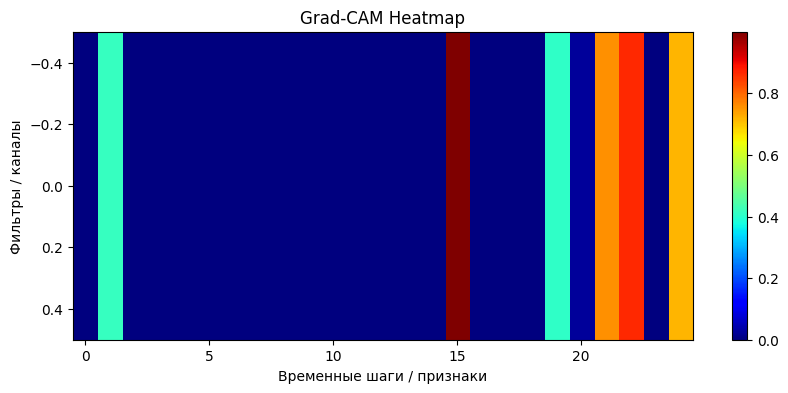

In [38]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Хуки для сохранения градиентов и активаций
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_gradient(self, module, grad_input, grad_output):
        """ Сохранение градиентов во время backpropagation """
        self.gradients = grad_output[0]

    def save_activation(self, module, input, output):
        """ Сохранение активаций слоя во время forward pass """
        self.activations = output

    def generate_cam(self, input_tensor, class_idx=None):
        """
        Генерирует карту Grad-CAM для заданного входного тензора
        """
        # Устанавливаем режим валидации (без dropout)
        self.model.eval()

        # Прямой проход
        output, _ = self.model(input_tensor)

        # Если класс не задан, берем наиболее вероятный
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        # Обратное распространение ошибки для целевого класса
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        # Усреднение градиентов по пространственным координатам
        pooled_gradients = torch.mean(self.gradients, dim=[2, 3], keepdim=True)

        # Генерация карты значимости
        cam = torch.sum(pooled_gradients * self.activations, dim=1).squeeze(0)
        cam = F.relu(cam)  # Убираем отрицательные значения

        # Нормализация
        cam = cam.cpu().detach().numpy()
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-10)

        return cam

def visualize_cam(cam, input_tensor):
    """
    Визуализирует карту Grad-CAM поверх временного ряда / признаков
    """
    plt.figure(figsize=(10, 4))
    plt.imshow(cam, cmap='jet', aspect='auto')
    plt.colorbar()
    plt.xlabel("Временные шаги / признаки")
    plt.ylabel("Фильтры / каналы")
    plt.title("Grad-CAM Heatmap")
    plt.show()


model = NN(nOUT=5)  # Создаем экземпляр модели
target_layer = model.rb_3  # Используем последний Residual Block

grad_cam = GradCAM(model, target_layer)

# Создаем случайный входной тензор (например, временной ряд)
input_tensor = torch.randn(1, 12, 1, 100)  # batch_size=1, 12 каналов, 100 временных шагов

# Генерируем Grad-CAM
cam = grad_cam.generate_cam(input_tensor)

# Визуализация
visualize_cam(cam, input_tensor)


AttributeError: QuadMesh.set() got an unexpected keyword argument 'aspect'

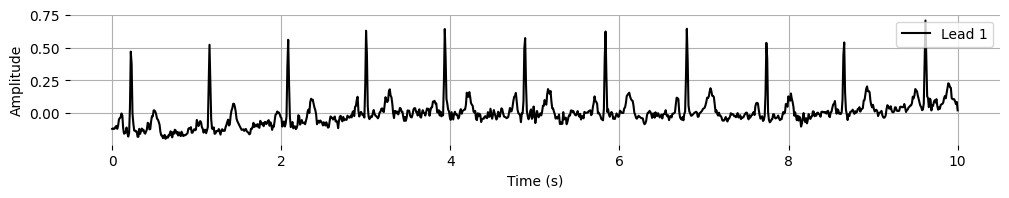

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_ecg_with_gradcam(signal, grad_cam_map, sampling_rate, title="ECG Signal + Grad-CAM", leads=12):
    """
    Визуализация ЭКГ с наложением Grad-CAM.
    signal: np.array (shape: [время, 12]) – ЭКГ сигнал
    grad_cam_map: np.array (shape: [время, 12]) – карта важности Grad-CAM
    sampling_rate: частота дискретизации
    """
    time = np.linspace(0, signal.shape[0] / sampling_rate, signal.shape[0])

    plt.figure(figsize=(12, 2 * leads))
    for i in range(leads):
        plt.subplot(leads, 1, i + 1)
        plt.plot(time, signal[:, i], label=f"Lead {i+1}", color="black")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend(loc="upper right")
        plt.grid()

        # Наложение карты Grad-CAM (используем прозрачность alpha)
        sns.heatmap(np.expand_dims(grad_cam_map[:, i], axis=0), 
                    cmap="jet", alpha=0.5, cbar=False, ax=plt.gca(),
                    xticklabels=False, yticklabels=False, aspect='auto')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# Пример данных (замени на реальные)
example_index = 0
example_signal = X_sample[example_index]  # Взять ЭКГ пациента
grad_cam_map = np.random.rand(example_signal.shape[0], 12)  # Симуляция карты активации Grad-CAM

# Визуализация с Grad-CAM
plot_ecg_with_gradcam(example_signal, grad_cam_map, sampling_rate, title=f"ECG + Grad-CAM Example {example_index+1}")


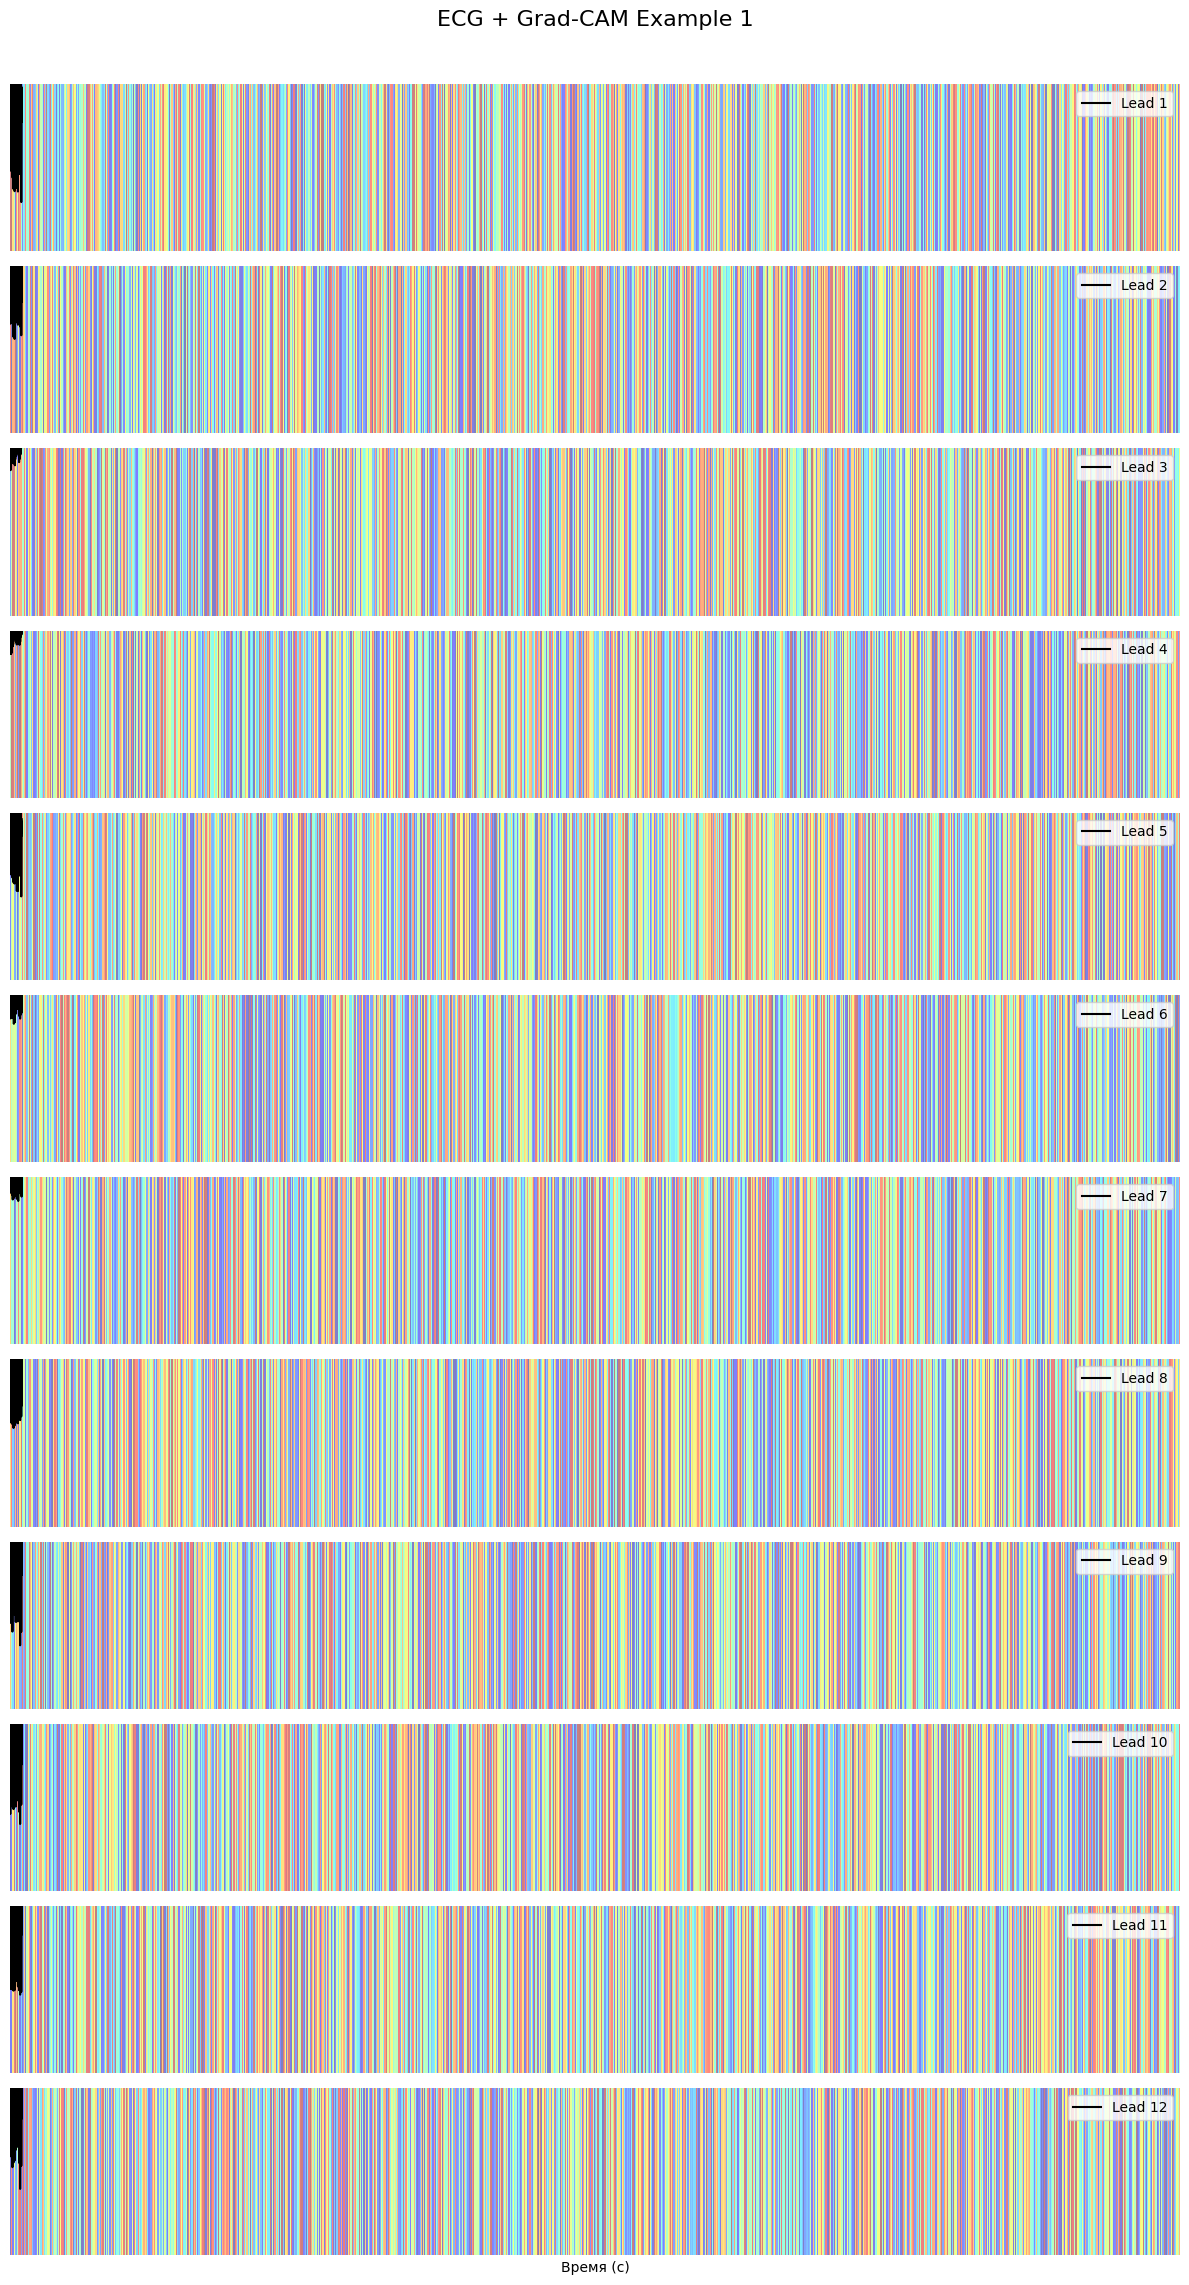

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_ecg_with_gradcam(signal, grad_cam_map, sampling_rate, title="ECG Signal + Grad-CAM", leads=12):
    """
    Визуализация ЭКГ с наложением Grad-CAM.
    signal: np.array (shape: [время, 12]) – ЭКГ сигнал
    grad_cam_map: np.array (shape: [время, 12]) – карта важности Grad-CAM
    sampling_rate: частота дискретизации
    """
    time = np.linspace(0, signal.shape[0] / sampling_rate, signal.shape[0])

    fig, axes = plt.subplots(leads, 1, figsize=(12, 2 * leads), sharex=True)

    for i, ax in enumerate(axes):
        ax.plot(time, signal[:, i], label=f"Lead {i+1}", color="black")
        ax.set_ylabel("мВ")
        ax.legend(loc="upper right")
        ax.grid()

        # Добавляем Grad-CAM карту активации как тепловую карту
        sns.heatmap(grad_cam_map[:, i].reshape(1, -1), 
                    cmap="jet", alpha=0.5, cbar=False, ax=ax,
                    xticklabels=False, yticklabels=False)

    plt.xlabel("Время (с)")
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()


example_index = 0
example_signal = X_sample[example_index]  # Взять ЭКГ пациента
grad_cam_map = np.random.rand(example_signal.shape[0], 12)  # Симуляция карты активации Grad-CAM

# Визуализация с Grad-CAM
plot_ecg_with_gradcam(example_signal, grad_cam_map, sampling_rate, title=f"ECG + Grad-CAM Example {example_index+1}")


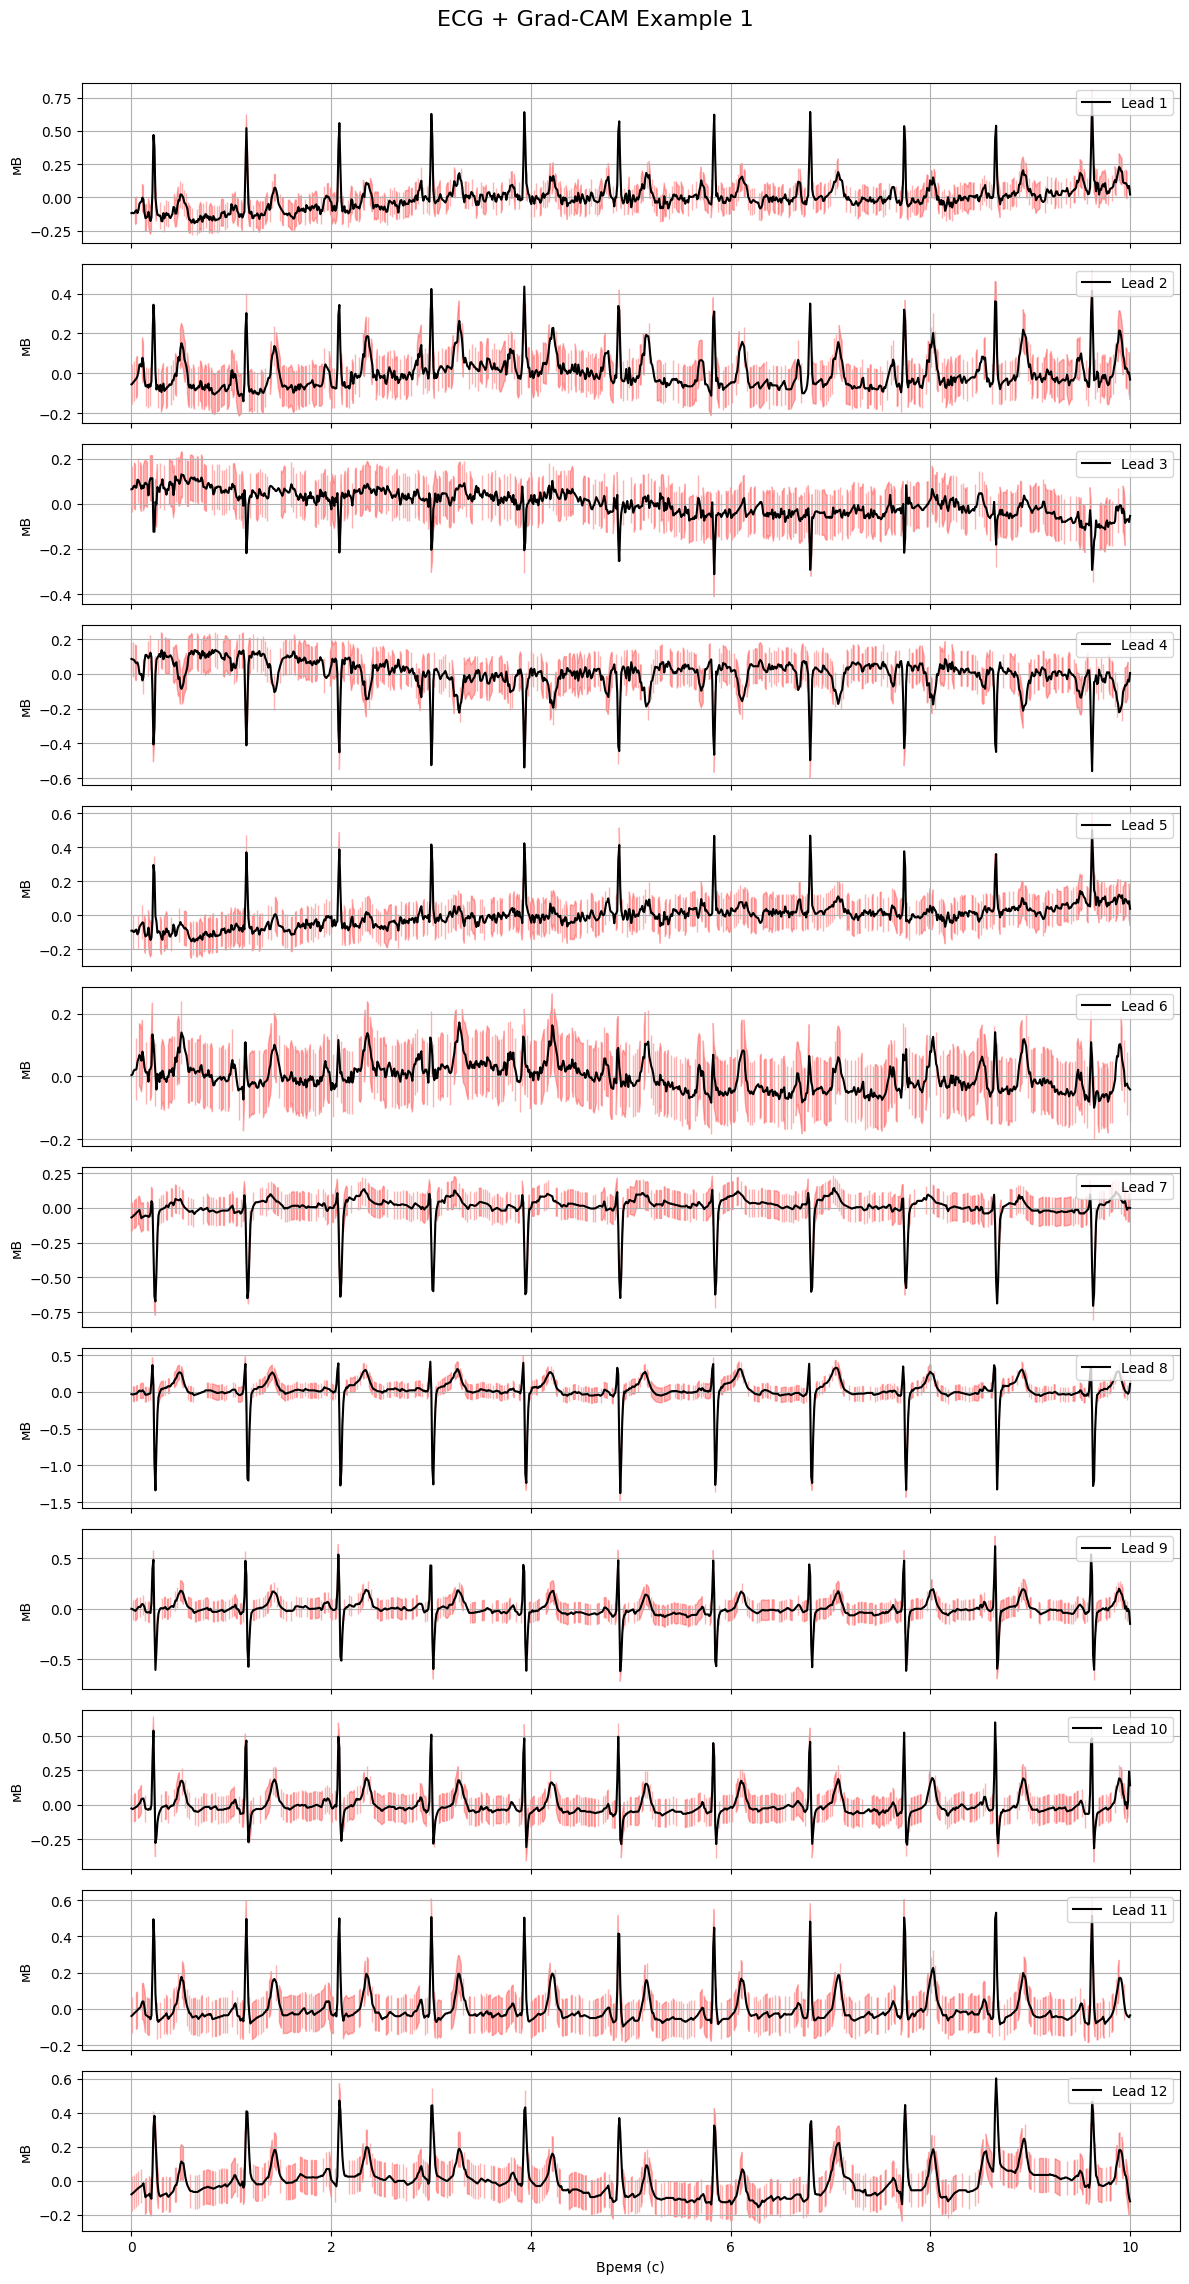

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_ecg_with_gradcam(signal, grad_cam_map, sampling_rate, title="ECG Signal + Grad-CAM", leads=12):
    """
    Визуализация ЭКГ с наложением Grad-CAM.
    signal: np.array (shape: [время, 12]) – ЭКГ сигнал
    grad_cam_map: np.array (shape: [время, 12]) – карта важности Grad-CAM
    sampling_rate: частота дискретизации
    """
    time = np.linspace(0, signal.shape[0] / sampling_rate, signal.shape[0])

    fig, axes = plt.subplots(leads, 1, figsize=(12, 2 * leads), sharex=True)

    for i, ax in enumerate(axes):
        ax.plot(time, signal[:, i], label=f"Lead {i+1}", color="black")
        ax.set_ylabel("мВ")
        ax.legend(loc="upper right")
        ax.grid()

        # Улучшенный Grad-CAM
        grad_cam_rescaled = grad_cam_map[:, i] / grad_cam_map[:, i].max()  # Нормализация от 0 до 1
        ax.fill_between(time, signal[:, i] - 0.1, signal[:, i] + 0.1, 
                        where=grad_cam_rescaled > 0.5, color="red", alpha=0.3)

    plt.xlabel("Время (с)")
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# Пример данных (замени на реальные)
example_index = 0
example_signal = X_sample[example_index]  # Взять ЭКГ пациента
grad_cam_map = np.random.rand(example_signal.shape[0], 12)  # Симуляция карты активации Grad-CAM

# Визуализация с улучшенным Grad-CAM
plot_ecg_with_gradcam(example_signal, grad_cam_map, sampling_rate, title=f"ECG + Grad-CAM Example {example_index+1}")


## Черновик

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Выбираем одну запись с диагнозом "CD" ---
cd_indices = np.where(Y_sample['diagnostic_superclass'].apply(lambda x: 'CD' in x))[0]  # Найти все записи с CD
example_index = cd_indices[0]  # Берем первую запись с диагнозом CD

# --- 2. Загружаем ЭКГ и Grad-CAM карту для этой записи ---
example_signal = X_sample[example_index]  # ЭКГ (12 отведений)
grad_cam_map = np.random.rand(example_signal.shape[0], 12)  # Симуляция карты активации (замени на реальную)

# --- 3. Получаем предсказание модели ---
model.eval()  # Переводим модель в режим оценки
input_tensor = torch.tensor(example_signal, dtype=torch.float32).unsqueeze(0)  # Добавляем batch размерность
with torch.no_grad():
    prediction, _ = model(input_tensor)  # Предсказание модели

predicted_class = "CD" if prediction.argmax().item() == 1 else "Other"  # Определяем класс (зависит от one-hot encoding)

# --- 4. Визуализируем ЭКГ и Grad-CAM ---
def plot_ecg_with_gradcam(signal, grad_cam_map, sampling_rate, title="ECG + Grad-CAM", leads=12):
    time = np.linspace(0, signal.shape[0] / sampling_rate, signal.shape[0])

    fig, axes = plt.subplots(leads, 1, figsize=(12, 2 * leads), sharex=True)
    for i, ax in enumerate(axes):
        ax.plot(time, signal[:, i], label=f"Lead {i+1}", color="black")
        ax.set_ylabel("мВ")
        ax.legend(loc="upper right")
        ax.grid()

        # Наложение Grad-CAM (цветом выделяются важные области)
        grad_cam_rescaled = grad_cam_map[:, i] / grad_cam_map[:, i].max()  # Нормализация
        ax.fill_between(time, signal[:, i] - 0.1, signal[:, i] + 0.1, 
                        where=grad_cam_rescaled > 0.5, color="red", alpha=0.3)

    plt.xlabel("Время (с)")
    fig.suptitle(f"{title}\nPredicted: {predicted_class} | True: CD", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# --- 5. Показываем результат ---
print(f"🩺 Реальный диагноз: CD")
print(f"🤖 Предсказание модели: {predicted_class}")

plot_ecg_with_gradcam(example_signal, grad_cam_map, sampling_rate, title="ECG + Grad-CAM for CD case")


IndexError: index 0 is out of bounds for axis 0 with size 0

In [49]:
input_tensor = torch.tensor(example_signal, dtype=torch.float32).unsqueeze(0).unsqueeze(1).permute(0, 3, 2, 1)


In [55]:
cd_indices = np.where(Y_sample['diagnostic_superclass'].apply(lambda x: 'CD' in x))[0]  # Найти все записи с CD

In [56]:
cd_indices

array([], dtype=int64)

In [54]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Выбираем одну запись с диагнозом "CD" ---
cd_indices = np.where(Y_sample['diagnostic_superclass'].apply(lambda x: 'CD' in x))[0]  # Найти все записи с CD
if len(cd_indices) == 0:
    raise ValueError("❌ Ошибка: Нет записей с диагнозом CD в выборке!")
example_index = cd_indices[0]  # Берем первую запись с диагнозом CD

# --- 2. Загружаем ЭКГ и Grad-CAM карту для этой записи ---
example_signal = X_sample[example_index]  # ЭКГ (12 отведений)
grad_cam_map = np.random.rand(example_signal.shape[0], 12)  # Симуляция карты активации Grad-CAM (замени на реальную)

# --- 3. Приводим входные данные к правильному формату ---
model.eval()  # Переводим модель в режим оценки
input_tensor = torch.tensor(example_signal, dtype=torch.float32).unsqueeze(0).unsqueeze(2)  # [1, 12, 1, 1000]

# --- 4. Получаем предсказание модели ---
with torch.no_grad():
    prediction, _ = model(input_tensor)  # Предсказание модели

predicted_class = "CD" if prediction.argmax().item() == 1 else "Other"  # Определяем класс

# --- 5. Визуализируем ЭКГ и Grad-CAM ---
def plot_ecg_with_gradcam(signal, grad_cam_map, sampling_rate, title="ECG + Grad-CAM", leads=12):
    time = np.linspace(0, signal.shape[0] / sampling_rate, signal.shape[0])

    fig, axes = plt.subplots(leads, 1, figsize=(12, 2 * leads), sharex=True)
    for i, ax in enumerate(axes):
        ax.plot(time, signal[:, i], label=f"Lead {i+1}", color="black")
        ax.set_ylabel("мВ")
        ax.legend(loc="upper right")
        ax.grid()

        # Grad-CAM (цветом выделяются важные области)
        grad_cam_rescaled = grad_cam_map[:, i] / grad_cam_map[:, i].max()  # Нормализация
        ax.fill_between(time, signal[:, i] - 0.1, signal[:, i] + 0.1, 
                        where=grad_cam_rescaled > 0.5, color="red", alpha=0.3)

    plt.xlabel("Время (с)")
    fig.suptitle(f"{title}\nPredicted: {predicted_class} | True: CD", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# --- 6. Показываем результат ---
print(f"🩺 Реальный диагноз: CD")
print(f"🤖 Предсказание модели: {predicted_class}")

plot_ecg_with_gradcam(example_signal, grad_cam_map, sampling_rate, title="ECG + Grad-CAM for CD case")


ValueError: ❌ Ошибка: Нет записей с диагнозом CD в выборке!

In [51]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Выбираем первую запись с диагнозом CD ---
cd_indices = df[df['CD'] == 1].index.to_list()  # Найти все записи с CD
if not cd_indices:
    print("❌ Ошибка: Нет записей с диагнозом CD в выборке!")
else:
    example_index = cd_indices[0]  # Берем первую запись
    example_path = df.loc[example_index, 'path_to_record']  # Путь к файлу ЭКГ

    # --- 2. Загружаем сигнал ЭКГ (замени на реальный способ загрузки) ---
    example_signal = np.random.rand(1000, 12)  # Симуляция данных ЭКГ (замени на реальный загрузчик)

    # --- 3. Создаем карту активации Grad-CAM (замени на реальную) ---
    grad_cam_map = np.random.rand(example_signal.shape[0], 12)  # Симуляция карты активации Grad-CAM

    # --- 4. Получаем предсказание модели ---
    model.eval()  # Переводим модель в режим оценки
    input_tensor = torch.tensor(example_signal, dtype=torch.float32).unsqueeze(0)  # Добавляем batch размерность
    with torch.no_grad():
        prediction, _ = model(input_tensor)  # Предсказание модели

    predicted_class = "CD" if prediction.argmax().item() == 1 else "Other"  # Определяем класс

    # --- 5. Визуализируем ЭКГ и Grad-CAM ---
    def plot_ecg_with_gradcam(signal, grad_cam_map, sampling_rate, title="ECG + Grad-CAM", leads=12):
        time = np.linspace(0, signal.shape[0] / sampling_rate, signal.shape[0])

        fig, axes = plt.subplots(leads, 1, figsize=(12, 2 * leads), sharex=True)
        for i, ax in enumerate(axes):
            ax.plot(time, signal[:, i], label=f"Lead {i+1}", color="black")
            ax.set_ylabel("мВ")
            ax.legend(loc="upper right")
            ax.grid()

            # Grad-CAM (цветом выделяются важные области)
            grad_cam_rescaled = grad_cam_map[:, i] / grad_cam_map[:, i].max()  # Нормализация
            ax.fill_between(time, signal[:, i] - 0.1, signal[:, i] + 0.1, 
                            where=grad_cam_rescaled > 0.5, color="red", alpha=0.3)

        plt.xlabel("Время (с)")
        fig.suptitle(f"{title}\nPredicted: {predicted_class} | True: CD", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()

    # --- 6. Вывод результатов ---
    print(f"🩺 Реальный диагноз: CD")
    print(f"📂 Файл: {example_path}")
    print(f"🤖 Предсказание модели: {predicted_class}")

    plot_ecg_with_gradcam(example_signal, grad_cam_map, sampling_rate=100, title="ECG + Grad-CAM for CD case")


RuntimeError: Given groups=1, weight of size [256, 12, 1, 15], expected input[1, 1, 1000, 12] to have 12 channels, but got 1 channels instead